## Import required modules

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

import riskfolio as pf
import riskfolio.PlotFunctions as plf

warnings.filterwarnings("ignore")

yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# 1) Get Nifty Constituent data


Pandas read_csv can also read csv from URLs
- read nifty 50 data from https://en.wikipedia.org/wiki/NIFTY_50

In [ ]:
nifty_constituents = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[1]
nifty_constituents.head()

,Company Name,Symbol,Sector
0,Adani Ports,ADANIPORTS,Infrastructure
1,Asian Paints,ASIANPAINT,Consumer Goods
2,Axis Bank,AXISBANK,Banking
3,Bajaj Auto,BAJAJ-AUTO,Automobile
4,Bajaj Finance,BAJFINANCE,Financial Services


# 2) Get price data of the stocks

- Add ".NS" to symbol 
- Use start = '2019-01-01' end = '2022-1-30' and download ohlc data from yfinance
- Use Only "Adj Close"

In [ ]:
nifty_constituents['Symbol'] = nifty_constituents['Symbol'] + ".NS"
nifty_constituents.head()

,Company Name,Symbol,Sector
0,Adani Ports,ADANIPORTS.NS,Infrastructure
1,Asian Paints,ASIANPAINT.NS,Consumer Goods
2,Axis Bank,AXISBANK.NS,Banking
3,Bajaj Auto,BAJAJ-AUTO.NS,Automobile
4,Bajaj Finance,BAJFINANCE.NS,Financial Services


In [ ]:
# Date range
start = '2019-01-01'
end = '2022-1-30'
# Tickers of assets
assets = list(nifty_constituents['Symbol'])

In [ ]:

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data['Adj Close']
# data.columns = assets


[*********************100%***********************]  50 of 50 completed


# 3) Daily returns of the stocks to build portfolio

In [ ]:
# Calculating returns
Y = data.pct_change().dropna()
Y.head()

,ADANIPORTS.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,BPCL.NS,BRITANNIA.NS,CIPLA.NS,COALINDIA.NS,DIVISLAB.NS,DRREDDY.NS,EICHERMOT.NS,GRASIM.NS,HCLTECH.NS,HDFC.NS,HDFCBANK.NS,HDFCLIFE.NS,HEROMOTOCO.NS,HINDALCO.NS,HINDUNILVR.NS,ICICIBANK.NS,INDUSINDBK.NS,INFY.NS,IOC.NS,ITC.NS,JSWSTEEL.NS,KOTAKBANK.NS,LT.NS,M&M.NS,MARUTI.NS,NESTLEIND.NS,NTPC.NS,ONGC.NS,POWERGRID.NS,RELIANCE.NS,SBILIFE.NS,SBIN.NS,SHREECEM.NS,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,UPL.NS,WIPRO.NS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,-1.9794%,0.8567%,-1.1558%,-1.2708%,-2.1152%,-1.6109%,-2.1440%,-2.5191%,0.4447%,-1.6251%,-1.9876%,-0.3084%,-0.2301%,-8.7639%,-2.1596%,-1.4065%,-1.4112%,-0.9124%,1.2293%,-2.5914%,-3.6813%,-0.9161%,0.2337%,-1.1908%,0.6015%,-0.3268%,-0.7428%,-5.0173%,-0.7877%,-1.1374%,-4.0926%,-2.7946%,0.1848%,-1.1432%,-0.9764%,-2.3750%,-1.3024%,0.4759%,-1.9025%,-0.1962%,1.4993%,-2.0539%,-2.8250%,-4.2850%,1.0774%,-0.9804%,0.4472%,-0.0773%,0.3981%,-0.3367%
2019-01-03,-0.8392%,0.3615%,-1.9515%,0.3473%,-0.0110%,-1.0654%,0.2719%,-1.5226%,0.6112%,-0.4178%,-0.7182%,-2.2435%,-0.9112%,-4.4931%,-1.9375%,0.2113%,-2.2114%,-0.7846%,0.0383%,-1.0471%,-2.4936%,0.2129%,-0.3703%,-1.0466%,0.0149%,-3.3516%,-0.6237%,-2.0956%,-0.4312%,-2.1396%,-3.1549%,-0.8792%,1.5564%,-2.4490%,-3.1622%,-1.1268%,-1.2337%,-0.2742%,-0.9527%,0.0499%,-0.8976%,-2.1202%,-1.4832%,-2.5119%,-1.2141%,-2.9211%,-0.1019%,-2.6472%,-1.3021%,-0.0154%
2019-01-04,1.0711%,-0.1765%,1.9163%,1.2160%,0.4253%,-0.3925%,2.8549%,1.9716%,-0.4209%,0.0781%,0.6383%,1.5717%,0.8788%,-0.5336%,0.8066%,-1.6871%,1.8458%,0.2675%,0.5622%,-0.8890%,0.8126%,-0.3746%,0.5368%,-0.7628%,-1.2105%,0.9800%,0.7531%,1.8751%,1.0281%,-0.4982%,1.0163%,0.4241%,-3.1761%,1.6388%,2.3174%,1.4763%,0.5399%,0.4666%,2.2501%,-1.2467%,-0.5274%,1.7853%,2.9509%,1.3299%,-1.2158%,-1.4684%,-0.2953%,0.3718%,1.3058%,-0.3226%
2019-01-07,-0.1308%,0.7324%,2.8809%,-2.7668%,-0.0515%,-0.8715%,0.7753%,-1.0850%,0.6757%,0.2438%,-0.8457%,1.7460%,-1.5904%,-1.3590%,1.7987%,0.9868%,0.0152%,0.1511%,-0.1144%,-1.0007%,-1.1143%,0.1824%,0.6846%,0.7073%,1.6111%,-0.3733%,0.2492%,0.6598%,-0.1082%,-0.3062%,0.5444%,1.7631%,-0.6000%,1.9554%,1.4756%,1.3017%,0.5552%,-0.0663%,-0.4536%,1.1029%,-0.6916%,0.5379%,2.5739%,-0.4409%,1.1216%,0.9397%,1.6802%,0.3117%,0.9717%,-0.0616%
2019-01-08,-0.7599%,0.3761%,2.1100%,1.3654%,0.5603%,-0.6481%,1.3233%,-1.0125%,-1.7256%,-0.0778%,-0.5117%,-1.8271%,0.4631%,1.0804%,1.9436%,0.3823%,-0.7071%,-0.8323%,0.4198%,0.4175%,-0.9830%,-0.7899%,3.3859%,1.1930%,-0.2456%,0.4121%,0.9231%,1.3973%,-1.4199%,-0.1156%,-0.8430%,1.0520%,2.0332%,-1.1104%,-0.2706%,-0.5543%,-0.0091%,1.6682%,3.0375%,-0.9919%,4.0042%,0.0930%,2.6233%,1.2049%,-0.2292%,0.3418%,0.2224%,-0.2661%,-1.5123%,0.4009%


# 4) Building portfolio using Riskfolio

In [ ]:
# Building the portfolio object
port = pf.Portfolio(returns=Y)

# Select method and estimate input parameters:

# Method to estimate expected returns based on historical data
method_mu='hist'
# Method to estimate covariance matrix based on historical data
method_cov='hist' 
# Estimate mean and covariance based on historical data
port.assets_stats(method_mu=method_mu, method_cov=method_cov)


In [ ]:
# Estimate optimal portfolio:
model='Classic' # Could be Classic(historical), BL(Black Litterman), FM(Factor Model) or BL_FM(Black litterman with factors)
rm = 'MV' # Risk measure used, there are 13 available risk measures
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
w.T

,ADANIPORTS.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,BPCL.NS,BRITANNIA.NS,CIPLA.NS,COALINDIA.NS,DIVISLAB.NS,DRREDDY.NS,EICHERMOT.NS,GRASIM.NS,HCLTECH.NS,HDFC.NS,HDFCBANK.NS,HDFCLIFE.NS,HEROMOTOCO.NS,HINDALCO.NS,HINDUNILVR.NS,ICICIBANK.NS,INDUSINDBK.NS,INFY.NS,IOC.NS,ITC.NS,JSWSTEEL.NS,KOTAKBANK.NS,LT.NS,M&M.NS,MARUTI.NS,NESTLEIND.NS,NTPC.NS,ONGC.NS,POWERGRID.NS,RELIANCE.NS,SBILIFE.NS,SBIN.NS,SHREECEM.NS,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,UPL.NS,WIPRO.NS
weights,0.0000%,11.7648%,0.0000%,0.0000%,0.0000%,0.0000%,7.8763%,0.0000%,0.0000%,2.9501%,0.0000%,18.9108%,0.0000%,0.0000%,0.0000%,1.4405%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,17.5525%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,4.0513%,0.0000%,2.7870%,0.0000%,0.0000%,0.0000%,16.2740%,0.8429%,0.0000%,0.0003%,0.0000%,9.1792%,0.0000%,0.0000%,6.3703%


# 5) Plot of portfolio weights

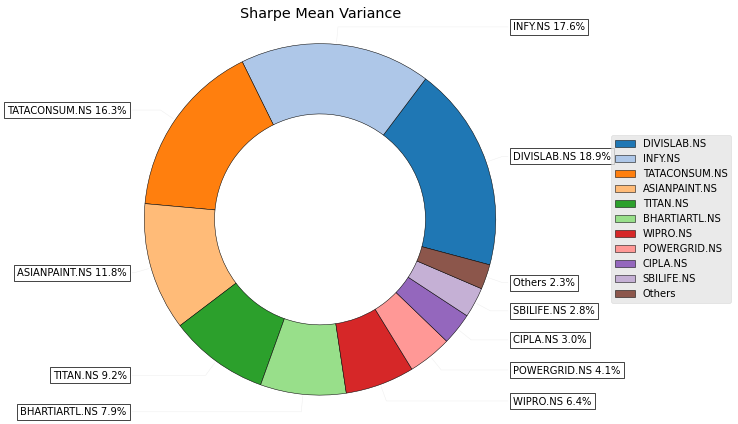

In [ ]:
# Plotting the composition of the portfolio
ax = plf.plot_pie(w=w, title='Sharpe Mean Variance',  height=6, width=10)

# 6) Plot of efficient frontier of the portfolios

Actual returns and stdevs of the stocks

In [ ]:
daily_std= Y.std()
daily_ret= Y.mean()
annualized_std = daily_std * math.sqrt(252) # 365 for bitcoin
annualized_ret = daily_ret*252 #
plot_df = pd.concat([annualized_ret,annualized_std, daily_ret,daily_std],axis=1)
plot_df.columns = ['Annualized Returns','Annualized Risk','Daily Returns','Daily Risk']
plot_df.head()

,Annualized Returns,Annualized Risk,Daily Returns,Daily Risk
ADANIPORTS.NS,28.4176%,39.4038%,0.1128%,2.4822%
ASIANPAINT.NS,31.9099%,28.5818%,0.1266%,1.8005%
AXISBANK.NS,16.1001%,43.0736%,0.0639%,2.7134%
BAJAJ-AUTO.NS,15.7221%,28.8164%,0.0624%,1.8153%
BAJAJFINSV.NS,36.7261%,41.0422%,0.1457%,2.5854%


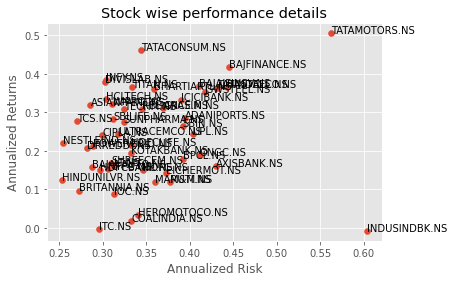

In [ ]:
plt.scatter(plot_df['Annualized Risk'],plot_df['Annualized Returns'])
for i in range(plot_df.shape[0]):
    plt.text(plot_df['Annualized Risk'][i],plot_df['Annualized Returns'][i],plot_df.index[i])
plt.xlabel('Annualized Risk')
plt.ylabel('Annualized Returns')
plt.title('Stock wise performance details')
plt.show()

Points required for plotting efficient frontier

In [ ]:
points = 100  # Number of points of the frontier
frontier = port.efficient_frontier(points=points)
print("Number of portfolios",frontier.shape)
frontier.T.head()

Number of portfolios (50, 100)


,ADANIPORTS.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,BPCL.NS,BRITANNIA.NS,CIPLA.NS,COALINDIA.NS,DIVISLAB.NS,DRREDDY.NS,EICHERMOT.NS,GRASIM.NS,HCLTECH.NS,HDFC.NS,HDFCBANK.NS,HDFCLIFE.NS,HEROMOTOCO.NS,HINDALCO.NS,HINDUNILVR.NS,ICICIBANK.NS,INDUSINDBK.NS,INFY.NS,IOC.NS,ITC.NS,JSWSTEEL.NS,KOTAKBANK.NS,LT.NS,M&M.NS,MARUTI.NS,NESTLEIND.NS,NTPC.NS,ONGC.NS,POWERGRID.NS,RELIANCE.NS,SBILIFE.NS,SBIN.NS,SHREECEM.NS,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,UPL.NS,WIPRO.NS
0,0.0000%,4.0474%,0.0000%,2.3368%,0.0000%,0.0000%,1.5002%,0.0000%,4.0098%,9.5367%,3.0238%,2.1835%,8.8105%,0.0000%,0.0000%,0.0000%,0.0000%,5.2493%,0.0000%,0.0000%,0.0000%,6.5749%,0.0000%,0.0000%,1.4974%,3.3820%,8.0115%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,12.3219%,0.3614%,0.0000%,12.2516%,0.0000%,1.6028%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,12.5078%,0.0000%,0.0000%,0.0000%,0.0000%,0.7908%
1,0.0000%,8.8945%,0.0000%,0.8287%,0.0000%,0.0000%,3.9471%,0.0000%,0.0611%,8.9287%,0.0000%,6.6103%,6.4250%,0.0000%,0.0000%,0.0017%,0.0000%,2.2647%,0.0000%,0.0000%,0.0000%,1.5911%,0.0000%,0.0000%,5.0304%,1.6368%,2.2032%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,12.9775%,0.0000%,0.0000%,13.6519%,0.0000%,3.9904%,0.0000%,0.0000%,1.8317%,1.3552%,0.0000%,0.0000%,11.9745%,0.0000%,2.3612%,0.0000%,0.0000%,3.4343%
2,0.0000%,10.4834%,0.0000%,0.0000%,0.0000%,0.0000%,4.9530%,0.0000%,0.0000%,8.4484%,0.0000%,8.5802%,4.8899%,0.0000%,0.0000%,0.1443%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,6.7423%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,11.3703%,0.0000%,0.0000%,13.7446%,0.0000%,4.8806%,0.0000%,0.0000%,2.2564%,3.6384%,0.0000%,0.0000%,11.1550%,0.0000%,4.3227%,0.0000%,0.0000%,4.3903%
3,0.0000%,11.2811%,0.0000%,0.0000%,0.0000%,0.0000%,5.6354%,0.0000%,0.0000%,7.8063%,0.0000%,11.2030%,2.5412%,0.0000%,0.0000%,0.5934%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,9.2306%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,7.8170%,0.0000%,0.0000%,11.7407%,0.0000%,4.6399%,0.0000%,0.0000%,1.6568%,6.6083%,0.0000%,0.0000%,8.6028%,0.0000%,5.5335%,0.0000%,0.0000%,5.1099%
4,0.0000%,11.8681%,0.0000%,0.0000%,0.0000%,0.0000%,6.1376%,0.0000%,0.0000%,7.3338%,0.0000%,13.1331%,0.8128%,0.0000%,0.0000%,0.9228%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,11.0620%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,5.2023%,0.0000%,0.0000%,10.2662%,0.0000%,4.4629%,0.0000%,0.0000%,1.2156%,8.7938%,0.0000%,0.0000%,6.7249%,0.0000%,6.4245%,0.0000%,0.0000%,5.6397%


Plot the efficient frontier

(0.0, 0.7)

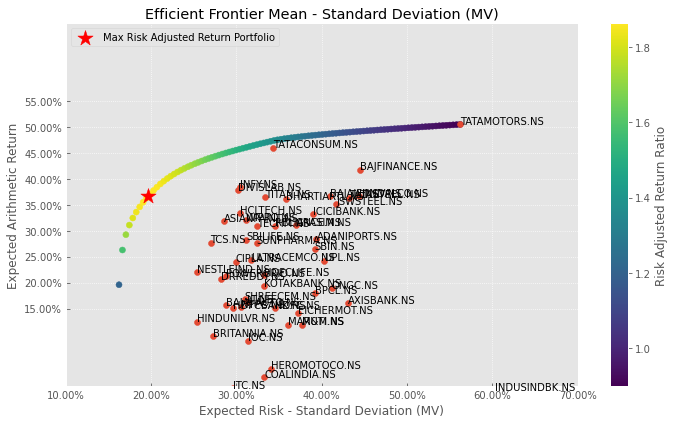

In [ ]:
# Plotting the efficient frontier
label = 'Max Risk Adjusted Return Portfolio' # Title of plot
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets
ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05, cmap='viridis', w=w, label=label, marker='*', s=16, c='r', height=6, width=10, ax=None)

ax.scatter(plot_df['Annualized Risk'],plot_df['Annualized Returns'])
for i in range(plot_df.shape[0]):
    ax.text(plot_df['Annualized Risk'][i],plot_df['Annualized Returns'][i],plot_df.index[i])
ax.set_ylim(0,0.7)

# 7) Plotting the composition of portfolios on the frontier

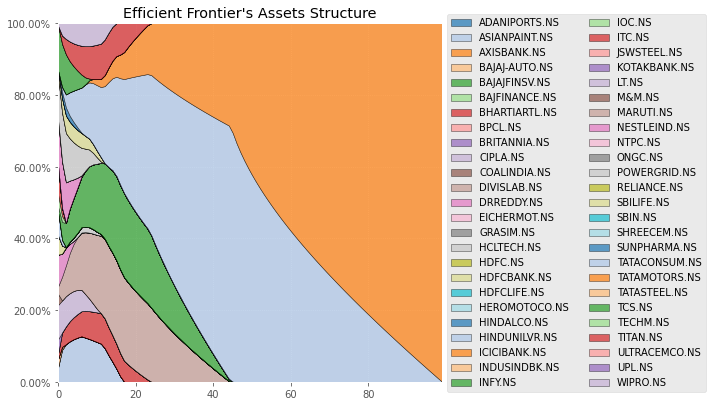

In [ ]:
# Plotting efficient frontier composition
ax = plf.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

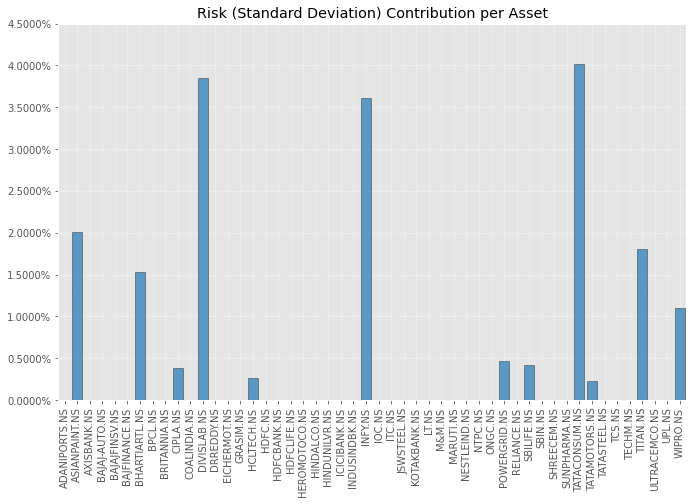

In [ ]:
ax = pf.plot_risk_con(w=w, cov=cov, returns=returns, rm=rm,
                      rf=0, alpha=0.05, color="tab:blue", height=6,
                      width=10, t_factor=252, ax=None)
plt.xticks(rotation = 90)
plt.show()


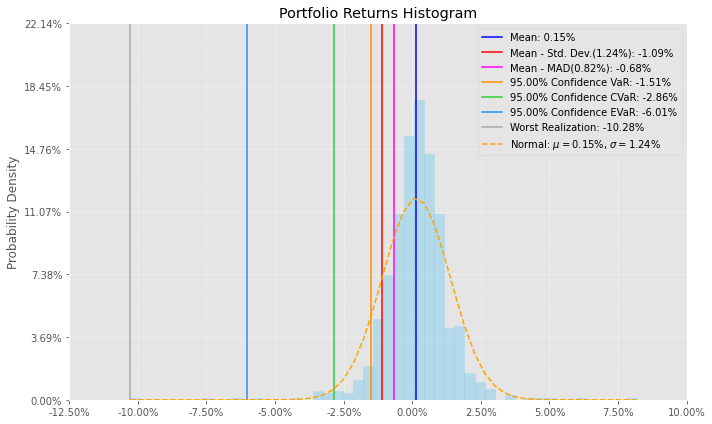

In [ ]:
ax = pf.plot_hist(returns=Y, w=w, alpha=0.05, bins=50, height=6,
                  width=10, ax=None)

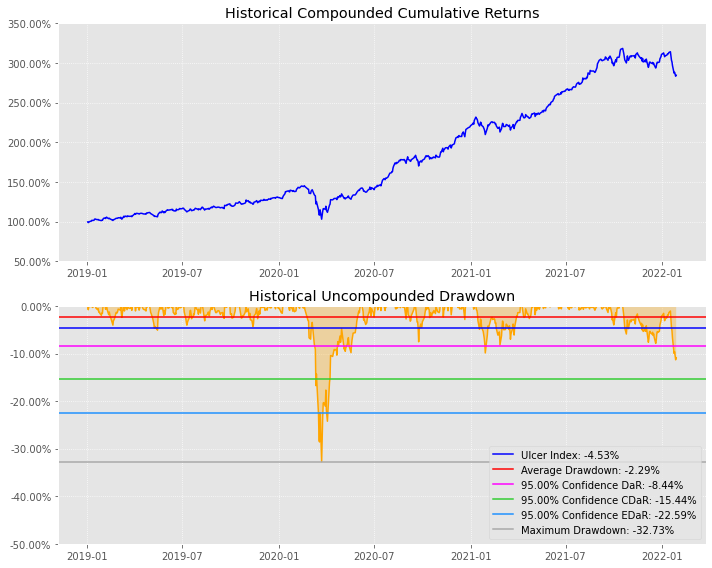

In [ ]:
nav=port.nav

ax = pf.plot_drawdown(nav=nav, w=w, alpha=0.05, height=8, width=10, ax=None)

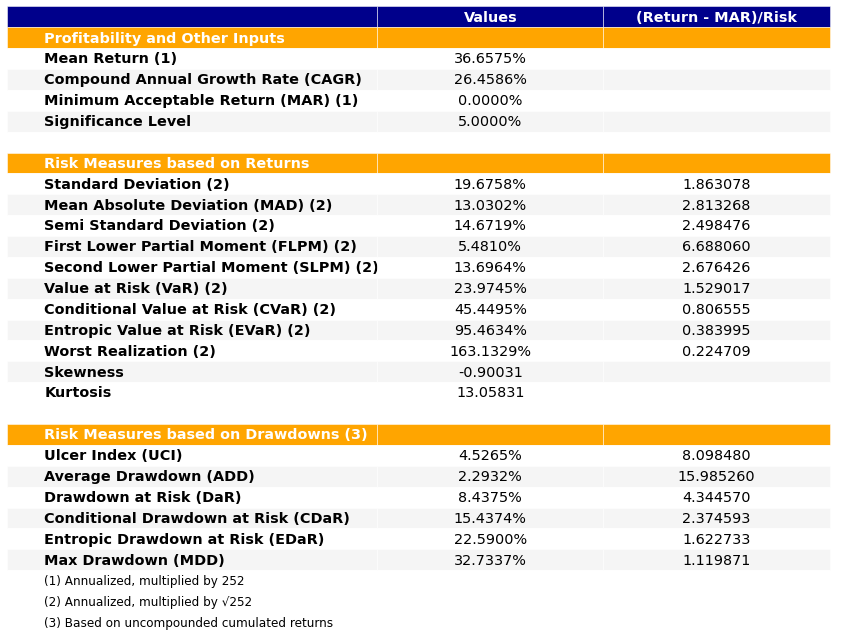

In [ ]:
ax = pf.plot_table(returns=Y, w=w, MAR=0, alpha=0.05, ax=None)